<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Привет! Поздравляю тебя с первым твоим проектом и спасибо, что сдала задание:) Ты проделала большую работу. Далее в файле мои комментарии ты сможешь найти в ячейках, аналогичных данфной ( если рамки комментария зелёные - всё сделано правильно; жёлтые - есть замечания, но не критично; красные - нужно переделать). Не удаляй эти комментарии и постарайся учесть их в ходе выполнения проекта. 

## Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [47]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem
m = Mystem()
import re
data = pd.read_csv('/datasets/data.csv')
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


children  days_employed  dob_years education  education_id  \
0         1   -8437.673028         42    высшее             0   
1         1   -4024.803754         36   среднее             1   
2         0   -5623.422610         33   Среднее             1   
3         3   -4124.747207         32   среднее             1   
4         0  340266.072047         53   среднее             1   
5         0    -926.185831         27    высшее             0   
6         0   -2879.202052         43    высшее             0   
7         0    -152.779569         50   СРЕДНЕЕ             1   
8         2   -6929.865299         35    ВЫСШЕЕ             0   
9         0   -2188.756445         41   среднее             1   

      family_status  family_status_id gender income_type  debt   total_income  \
0   женат / замужем                 0      F   сотрудник     0  253875.639453   
1   женат / замужем                 0      F   сотрудник     0  112080.014102   
2   женат / замужем                 0      M   сотрудник     0  145885.952297   
3   женат / замужем                 0      M   сотрудник     0  267628.550329   
4  гражданский брак                 1      F   пенсионер     0  158616.077870   
5  гражданский брак                 1      M   компаньон     0  255763.565419   
6   женат / замужем                 0      F   компаньон     0  240525.971920   
7   женат / замужем                 0      M   сотрудник     0  135823.934197   
8  гражданский брак                 1      F   сотрудник     0   95856.832424   
9   женат / замужем                 0      M   сотрудник     0  144425.938277   

                      purpose  
0               покупка жилья  
1     приобретение автомобиля  
2               покупка жилья  
3  дополнительное образование  
4             сыграть свадьбу  
5               покупка жилья  
6           операции с жильем  
7                 образование  
8       на проведение свадьбы  
9     покупка жилья для семьи

In [48]:
print('Пропущенных значений в колонке days_employed -', data['days_employed'].isna().sum(), 'шт.')
print('Пропущенных значений в колонке total_income - ', data['total_income'].isna().sum(), 'шт.')
print('Процент пропущенных значений - {:.0%}'.format(2174 / len(data)))
nan_val= data[data['total_income'].isna()]

Пропущенных значений в колонке days_employed - 2174 шт.
Пропущенных значений в колонке total_income -  2174 шт.
Процент пропущенных значений - 10%


### Вывод

В датафрейме есть пара колонок с вещественным типом числа, что неудобно и нужно будет переводить их значения в целочисленный. Сразу видно, что в колонке с образованием есть "скачущие" значения, которые обозначают одно и тоже. Названия колонок я решила не менять, т.к. нет "скачущих" названий или названий на другом языке.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Отличное и очень детально начало, так держать!)


### Шаг 2. Предобработка данных

### Обработка пропусков

т.к. пропусков достаточно много, то удалять их или игнорировать будет неверным решением. Результаты и выводы могут быть искажены, поэтому на основе других данных пропущенные значения будут заменены медианой или средним значением. До замены нужно привести остальные колонки в порядок. Ниже список колонок, чтобы отмечать какие проблемы были и чек-лист решена ли проблема
- [x]  children. Есть отрицательные значения; 20 детей;
- [ ]  days_employed. Есть отрицательные значения; значения, которые не могут быть верными, например, 932 года трудового стажа; Nan;
- [X]  dob_years. Есть нулевые значения;
- [x]  education. Есть 15 уникальных значений, т.к. обозначения написаны разными регистрами;
- [x]  education_id. Это численный повтор колонки education;
- [x]  family_status. Нужно привести к одному регистру 1 уникальное значение;
- [x]  family_status_id. Это численный повтор колонки family_status;
- [x]  gender. Есть 1 строка с XNA, что не является гендером;
- [x]  income_type. Все ок;
- [x]  debt. Все ок;
- [x]  total_income. Nan;
- [x]  purpose. Слишком много уникальных значений, их нужно привести к 4-5 видам;

### Education и family_status
Пока приведу в порядок колонки с самыми простыми "проблемами". Это колонка education и  family_status. Здесь же хочу разобраться с education_id и  family_status_id.

In [49]:
print(data['education'].value_counts())
data['education'] = data['education'].str.lower()
data['family_status'] = data['family_status'].str.lower()
print(data['education'].value_counts())
print(data['education_id'].value_counts())
print(data['family_status'].value_counts())
print(data['family_status_id'].value_counts())

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64
среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64
1    15233
0     5260
2      744
3      282
4        6
Name: education_id, dtype: int64
женат / замужем          12380
гражданский брак          4177
не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64
0    12380
1     4177
4     2813
3     1195
2      960
Name: family_status_id, dtyp

In [50]:
data = data.drop('education_id', axis = 1)
data = data.drop('family_status_id', axis = 1)

Привели в порядок данные по образованию, теперь всего 5 групп, вместо 15. Колонка education_id является повторением колонки education, только в численном выражениие. Аналогично с family_status и family_status_id. По моему мнению они не нужны, потому что не отражают сути сразу. К примеру, 0 не говорит о том, что человек состоит в браке. Скорее это больше запутает. Поэтому я решила убрать эти две колонки.

### Gender

In [51]:
data['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

In [52]:
data[data['gender'] == 'XNA']

children  days_employed  dob_years            education  \
10701         0   -2358.600502         24  неоконченное высшее   

          family_status gender income_type  debt   total_income  \
10701  гражданский брак    XNA   компаньон     0  203905.157261   

                    purpose  
10701  покупка недвижимости

Нужно определить кого больше мужчин или женщин с неоконченным высшим образованием в гражданском браке и с должностью "компаньон". По остальным колонкам не определяю, т.к. там есть пропущенные или неверные значения.

In [53]:
not_finish_hight = data[data['education'] == 'неоконченное высшее']
print(not_finish_hight['gender'].value_counts())
gr_marry = data[data['family_status'] == 'гражданский брак']
print(gr_marry['gender'].value_counts())
compan = data[data['income_type'] == 'компаньон']
print(compan['gender'].value_counts())

F      460
M      283
XNA      1
Name: gender, dtype: int64
F      2868
M      1308
XNA       1
Name: gender, dtype: int64
F      3197
M      1887
XNA       1
Name: gender, dtype: int64


- Женщин с неоконченным высшим больше, чем мужчин в 1,6 раза;
- Женщин больше в гражданском браке, чем мужчин в 2,1 раза;
- Женщин со статусом "компаньон" больше, чем мужчин в 1,7 раза.
XNA - женщина по данным, которые у нас есть. Значит нужно заменить значение XNA на F.

In [54]:
data['gender'] = data['gender'].replace('XNA', 'F')
data['gender'].value_counts()

F    14237
M     7288
Name: gender, dtype: int64

### Ghildren

In [55]:
data['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

In [56]:
data['children'] = data['children'].replace(-1, 1)
data['children'] = data['children'].replace(20, 2)
data['children'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

В колонке children есть отрицательное значение и всплеск "20". Последний скорее всего ошибка, т.к. с 5-ю детьми всего лишь 9 человек, а с 20-ю - 76 человек. Т.к. общий вклад людей с 20-ю и -1-м ребенком = 76+47 = 123 / 21525 =  0,6 %, то можно заменить эти значения на 2 и 1 соответственно. Подобное изменение приведет только к измению на 0,22 - 0,35% уникальных значений
- children[1] = 4818 / 21525 * 100 = 22,38%
- children[1] + children[-1] = (4818+47) / 21525 * 100 = 22,60%
- children[2] = 2055 / 21525 * 100 = 9,55%
- children[2] + children[20] = (2055+76) / 21525 * 100 = 9,90%

### Dob_years

In [57]:
print(data['dob_years'].value_counts())
for i in data['dob_years'].unique():
    if i < 18:
        print('Меньше 18 лет -', i, 'лет')
print('Максимальное количество лет в выборке -', data['dob_years'].max(), 'лет')

35    617
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
43    513
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    264
23    254
65    194
66    183
22    183
67    167
21    111
0     101
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: dob_years, dtype: int64
Меньше 18 лет - 0 лет
Максимальное количество лет в выборке - 75 лет


Так как уникальных значений в dob_years было много, чтобы не допустить ошибку написала скрипт, который возвращает количество лет, меньше 18. Лицам младше 18 лет кредит не оформляют. Обнаружились только нулевые значения. Проверила также максимальную планку, она равна 75 лет. Следовательно, нужно разобраться с нулями. Их в выборке 101. Нули можно заменить исходя из значений в колонке income_type. Например, вычислить среднее значение лет у пенсионера и подставить вместо нулей в возрасте у пенсионеров. Составим выборку, где нет нулевых значений в возрасте и посмотрим количество, среднее арифметическое и медиану для дальнейшей подстановки.

In [58]:
dob_not_zero = data[data['dob_years'] != 0] 
dob_zero = data[data['dob_years'] == 0]
print(dob_zero['income_type'].unique())
dob_not_zero.groupby('income_type')['dob_years'].agg(['count', 'mean', 'median']) 

['пенсионер' 'сотрудник' 'компаньон' 'госслужащий']


count       mean  median
income_type                              
безработный          2  38.000000    38.0
в декрете            1  39.000000    39.0
госслужащий       1453  40.804542    40.0
компаньон         5065  39.854294    39.0
пенсионер         3836  59.370959    60.0
предприниматель      2  42.500000    42.5
сотрудник        11064  40.018980    39.0
студент              1  22.000000    22.0

Меня интересуют значения у пенсионеров, сотрудников, компаньонов и госслужащих. Данных у этих групп больше, чем у остальных. Медиана и среднее арифметическое практически не отличаются друг от друга. Подставим медиану вместо нулей, т.к. пенсия начинается обычно с 60 лет, чем с 59 лет.

In [59]:
def no_zero(value, years):
    data.loc[data['income_type'] == value, 'dob_years'] = data['dob_years'].replace(0, years)
no_zero('пенсионер', 60)
no_zero('сотрудник', 39)
no_zero('компаньон', 39)
no_zero('госслужащий', 40)

На всякий случай проверим сработала ли замена в функции

In [60]:
for i in data['dob_years'].unique():
    if i == 0:
        print('I found a zero')
print('Checked')

Checked


### Total_income

Остались Nan в колонках total_income и days_employed. В начале я планировала найти зависимости этих колонок от других, которые уже известны, выделить группы 4-5 шт., чтобы проставить среднее или медианное значение вместо пропусков. Но в задаче стоит вопрос о влиянии колонок children и family_status на debt, поэтому не вижу смысла тратить время на обработку пропусков, которые не повляют на результаты.

In [61]:
total_nan = data[data['total_income'].isnull() == True]
total_nan['days_employed'].unique()

array([nan])

Убедилась, что Nan в таблице есть только в 2 колонках и на одних и тех же строках. Посчитаю среднее и медиану и заполню пропуски.

In [62]:
mean_total = data['total_income'].mean()
median_total = data['total_income'].median()
print('Минимальное -', data['total_income'].min())
print('Максимальное -', data['total_income'].max())
print('Среднее -', mean_total)
print('Медиана -', median_total)
data['total_income'] = data['total_income'].fillna(median_total)


Минимальное - 20667.26379327158
Максимальное - 2265604.028722744
Среднее - 167422.30220817294
Медиана - 145017.93753253992


In [63]:
data['total_income'].isna().sum()

0

Пропусков в колонке больше нет. Я решила использовать медиану, т.к. разница между медианой и средним арифметическим небольшая (167422,3 - 156400,3 = 11022).  

### Вывод

У меня остались пропуски в данных по колонке с трудовым стажем. К тому же там отрицательные и неоднозначные данные. Думаю, что это произошло от возможных манипуляций с форматом данных или импортами из какой-то базы. В остальных колонках пропуски заполнены и можно приступить к замене типа данных и дальнейшей обработке данных.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Пропуски заполнены, молодец)

### Замена типа данных

In [64]:
data['total_income'].dtypes
data['total_income'] = data['total_income'].astype('int64')
data['total_income'].dtypes

dtype('int64')

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 10 columns):
children         21525 non-null int64
days_employed    19351 non-null float64
dob_years        21525 non-null int64
education        21525 non-null object
family_status    21525 non-null object
gender           21525 non-null object
income_type      21525 non-null object
debt             21525 non-null int64
total_income     21525 non-null int64
purpose          21525 non-null object
dtypes: float64(1), int64(4), object(5)
memory usage: 1.6+ MB


### Вывод

Заменила float64 на int64, чтобы убрать значения после запятой. Использую метод .dtype() для этого, потому что это простой способ преобразования типа данных в pandas. Не нужно затрачивать ресурсы на перебор каждого значения в Series с помощью цикла.  
Тип float64 остался только в колонке по дням занятости, но там есть Nan и замена методом .dtype() не сработает.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Замена типа данных выполнена верно

### Обработка дубликатов

In [66]:
dupls = data.duplicated()
dupls = data[dupls]
print('Количество дублей -', len(dupls), 'шт.')
print('Процентное отношение к фрейму -', '{:.1%}'.format(len(dupls)/len(data)))
dupls

Количество дублей - 71 шт.
Процентное отношение к фрейму - 0.3%


children  days_employed  dob_years education     family_status gender  \
2849          0            NaN         41   среднее   женат / замужем      F   
3290          0            NaN         58   среднее  гражданский брак      F   
4182          1            NaN         34    высшее  гражданский брак      F   
4851          0            NaN         60   среднее  гражданский брак      F   
5557          0            NaN         58   среднее  гражданский брак      F   
...         ...            ...        ...       ...               ...    ...   
20702         0            NaN         64   среднее   женат / замужем      F   
21032         0            NaN         60   среднее   женат / замужем      F   
21132         0            NaN         47   среднее   женат / замужем      F   
21281         1            NaN         30    высшее   женат / замужем      F   
21415         0            NaN         54   среднее   женат / замужем      F   

      income_type  debt  total_income                            purpose  
2849    сотрудник     0        145017            покупка жилья для семьи  
3290    пенсионер     0        145017                    сыграть свадьбу  
4182    сотрудник     0        145017                            свадьба  
4851    пенсионер     0        145017                            свадьба  
5557    пенсионер     0        145017                    сыграть свадьбу  
...           ...   ...           ...                                ...  
20702   пенсионер     0        145017         дополнительное образование  
21032   пенсионер     0        145017              заняться образованием  
21132   сотрудник     0        145017                       ремонт жилью  
21281   сотрудник     0        145017  покупка коммерческой недвижимости  
21415   пенсионер     0        145017                  операции с жильем  

[71 rows x 10 columns]

In [67]:
data.drop_duplicates().reset_index(drop = True)

children  days_employed  dob_years education     family_status gender  \
0             1   -8437.673028         42    высшее   женат / замужем      F   
1             1   -4024.803754         36   среднее   женат / замужем      F   
2             0   -5623.422610         33   среднее   женат / замужем      M   
3             3   -4124.747207         32   среднее   женат / замужем      M   
4             0  340266.072047         53   среднее  гражданский брак      F   
...         ...            ...        ...       ...               ...    ...   
21449         1   -4529.316663         43   среднее  гражданский брак      F   
21450         0  343937.404131         67   среднее   женат / замужем      F   
21451         1   -2113.346888         38   среднее  гражданский брак      M   
21452         3   -3112.481705         38   среднее   женат / замужем      M   
21453         2   -1984.507589         40   среднее   женат / замужем      F   

      income_type  debt  total_income                       purpose  
0       сотрудник     0        253875                 покупка жилья  
1       сотрудник     0        112080       приобретение автомобиля  
2       сотрудник     0        145885                 покупка жилья  
3       сотрудник     0        267628    дополнительное образование  
4       пенсионер     0        158616               сыграть свадьбу  
...           ...   ...           ...                           ...  
21449   компаньон     0        224791             операции с жильем  
21450   пенсионер     0        155999          сделка с автомобилем  
21451   сотрудник     1         89672                  недвижимость  
21452   сотрудник     1        244093  на покупку своего автомобиля  
21453   сотрудник     0         82047         на покупку автомобиля  

[21454 rows x 10 columns]

### Вывод

Стало очевидно, что в таблице есть дубли. В выведенной таблице с дублями видно, что дубль в колонке total_income, сумма общего дохода одинаковая для 71 человека. При этом что значения в колонках разные, но количество маленькое 0.3%  
Удаление этих строк не должно повлиять на результаты.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Дубликаты найдены и обработаны верно,отлично


### Лемматизация

In [68]:
purpose = data['purpose'].unique()
print('Количество уникальных значений в цели выдачи кредита -', len(purpose), 'шт.')
purpose

Количество уникальных значений в цели выдачи кредита - 38 шт.


array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Очевидно, что нужно привести 38 целей к 4-5 шт. Приведу уникальные значения к леммам, удалю пробелы, дубликаты и выделю похожие. Потом запишу словарь для того, чтобы функция в нокую колонку ставила значение по найденному ключу в purpose

In [69]:
lemmas = []
for i in purpose:
    a = m.lemmatize(i)
    for j in a:
        lemmas.append(j)
print('Отсортированные леммы -', sorted(lemmas))

Отсортированные леммы - ['\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', '\n', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'автомобиль', 'автомобиль', 'автомобиль', 'автомобиль', 'автомобиль', 'автомобиль', 'автомобиль', 'автомобиль', 'автомобиль', 'высокий', 'высокий', 'высокий', 'для', 'для', 'дополнительный', 'дополнительный', 'жилой', 'жилой', 'жилье', 'жилье', 'жилье', 'жилье', 'жилье', 'жилье', 'жилье', 'заниматься', 'заниматься', 'коммерческий', 'коммерческий', 'на', 'на', 'на', 'на', 'недвижимость', 'недвижимость', 'недвижимость', 'недвижимость', 'недвижимость'

In [70]:
lemmas = list(dict.fromkeys(lemmas)) #Удаляю дубликаты и вывожу отсортированный список
sorted(lemmas)

['\n',
 ' ',
 'автомобиль',
 'высокий',
 'для',
 'дополнительный',
 'жилой',
 'жилье',
 'заниматься',
 'коммерческий',
 'на',
 'недвижимость',
 'образование',
 'операция',
 'подержанный',
 'подержать',
 'покупка',
 'получение',
 'приобретение',
 'проведение',
 'профильный',
 'ремонт',
 'с',
 'свадьба',
 'свой',
 'сдача',
 'сделка',
 'семья',
 'со',
 'собственный',
 'строительство',
 'сыграть']

In [71]:
def del_short(mylist, number):  #функция для того, чтобы убрать слова меньше заданного в аргументе числа
    for i in mylist:
        if len(i) < number:
            mylist.remove(i)
del_short(lemmas, 4)
lemmas

['покупка',
 'жилье',
 'приобретение',
 'автомобиль',
 'дополнительный',
 'образование',
 'сыграть',
 'свадьба',
 'операция',
 'на',
 'проведение',
 'семья',
 'недвижимость',
 'коммерческий',
 'жилой',
 'строительство',
 'собственный',
 'подержать',
 'свой',
 'заниматься',
 'сделка',
 'подержанный',
 'получение',
 'высокий',
 'профильный',
 'сдача',
 'ремонт']

Вырисовываются следующие группы по целям кредита:
- недвижимость. Здесь будут все операции с жильем, будь то покупка, ремонт или строительство и проч.
- автомобиль. Покупка, ремонт машины
- образование. Дополнительное, высшее и проч.
- свадьба

В основном, определяющие слова есть в колонке purpose, поэтому нет смысла делать очень большой словарь вхождений. Хватит синоминов и существительных.  
Есть непонятные слова, которые могут подходить под несколько вариантов. Например, "ремонт", поэтому нужно посмотреть, где есть такие вхождения и решить к какой группе целей ее отнести. Для этого напишу функцию для проверки. 

In [72]:
def what_is(list, word):
    for i in list:
        x = i.find(word)
        if x > -1:
            print(i)
            
what_is(purpose, 'операц')
what_is(purpose, 'сем')
what_is(purpose, 'сдач')
what_is(purpose, 'ремонт')

операции с жильем
операции с коммерческой недвижимостью
операции со своей недвижимостью
операции с недвижимостью
покупка жилья для семьи
покупка жилья для сдачи
ремонт жилью


### Вывод

Теперь нужно создать словарь для всех вхождений. Включу туда только сущетсвительные, т.к. глаголы не говорят о цели ничего. Я хочу сделать именно словарь, т.к. его можно при возможности расширить. Если бы я писала if-else, то его сложнее было бы дополнять.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>


Лемматизация проведена верно

### Категоризация данных

In [73]:
dictionary = {
     'жилье': 'недвижимость',
     'недвижимость': 'недвижимость',
     'автомобиль': 'автомобиль',
     'образование': 'образование',
     'свадьба': 'свадьба'

}

In [74]:
def uni_purpose(row):
    a = m.lemmatize(row)
    for i in a:
        if i in dictionary: 
            new_purpose = dictionary.get(i)
            return new_purpose

In [75]:
data['new_purpose'] = data['purpose'].apply(uni_purpose)
data.head()

children  days_employed  dob_years education     family_status gender  \
0         1   -8437.673028         42    высшее   женат / замужем      F   
1         1   -4024.803754         36   среднее   женат / замужем      F   
2         0   -5623.422610         33   среднее   женат / замужем      M   
3         3   -4124.747207         32   среднее   женат / замужем      M   
4         0  340266.072047         53   среднее  гражданский брак      F   

  income_type  debt  total_income                     purpose   new_purpose  
0   сотрудник     0        253875               покупка жилья  недвижимость  
1   сотрудник     0        112080     приобретение автомобиля    автомобиль  
2   сотрудник     0        145885               покупка жилья  недвижимость  
3   сотрудник     0        267628  дополнительное образование   образование  
4   пенсионер     0        158616             сыграть свадьбу       свадьба

In [76]:
data['new_purpose'].unique()

array(['недвижимость', 'автомобиль', 'образование', 'свадьба'],
      dtype=object)

### Вывод

Проверила, что нет пропусков и ничего лишнего кроме тех групп, которые я задала. Решила, что лучше сделать новую колонку, чтобы в случае дополнения новыми данными было видно изначальные записи, чтобы в случае чего дополнить цели.  
Я выбрала 4 группы (недвижимость, автомибиль, образование, свадьба), потому что они отличаются друг от друга размером долга.
1. На покупку или ремонт **недвижимости** идут большие средства, их отдают несколько лет чаще всего. Это категория расходов на порядок выше других. 
2. **Автомобиль** - достаточно дорогое приобретение, к тому же несет в себе дополнительные траты на ТО или бензин.
3. **Образование** - в случае работающих людей эта трата возможно принесет доп.доход, из-за перехода в другую сферу или повышение, т.е. долг может быть отдан быстрее. 
4. **Свадьба** - единоразовая трата, которая не несет в себе возможные убытки или доходы.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Категоризация проведена верно

### Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [77]:
have_child = data[data['children'] >=1 ] 
have_no_child = data[data['children'] == 0 ] 
debt = data[data['debt'] == 1] 
print('Количество людей с долгом и с детьми:', len(have_child[have_child['debt'] == 1]), 'шт.')
print('Количество людей с долгом без детей:', len(have_no_child[have_no_child['debt'] == 1]), 'шт.')
print('Всего долгов:', len(debt), 'шт.')

Количество людей с долгом и с детьми: 678 шт.
Количество людей с долгом без детей: 1063 шт.
Всего долгов: 1741 шт.


In [78]:
print('Отношение людей с детьми к общему числу долгов:', '{:.1%}'.format(len(have_child[have_child['debt'] == 1]) / len(debt)))
print('Отношение людей без детей к общему числу долгов:', '{:.1%}'.format(len(have_no_child[have_no_child['debt'] == 1]) / len(debt)))

Отношение людей с детьми к общему числу долгов: 38.9%
Отношение людей без детей к общему числу долгов: 61.1%


### Вывод

Есть обратная зависимоть наличия ребенка и долга по кредиту. Долгов у людей больше, если детей у них нет. Возможно, играет роль финансовое распределение денежных средств в семье. Когда есть дети, то родители берут ответственность за детей на себя и обеспечивают не только себя, а значит более граммотно начинают распоржаться деньгами и стараются не жить в долгах.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [79]:
debt = data[data['debt'] == 1]
debt['family_status'].unique()

array(['гражданский брак', 'не женат / не замужем', 'женат / замужем',
       'вдовец / вдова', 'в разводе'], dtype=object)

In [80]:
print('Количество людей в браке с долгом:', len(debt[debt['family_status'] == 'женат / замужем']), 'шт.')
print('Количество людей в гражданском браке с долгом:', len(debt[debt['family_status'] == 'гражданский брак']), 'шт.')
print('Количество людей не в браке с долгом:', len(debt[debt['family_status'] == 'не женат / не замужем']), 'шт.')
print('Количество овдовевших людей с долгом:', len(debt[debt['family_status'] == 'вдовец / вдова']), 'шт.')
print('Количество в разводе людей с долгом:', len(debt[debt['family_status'] == 'в разводе']), 'шт.')
print('Всего долгов:', len(debt), 'шт.')

Количество людей в браке с долгом: 931 шт.
Количество людей в гражданском браке с долгом: 388 шт.
Количество людей не в браке с долгом: 274 шт.
Количество овдовевших людей с долгом: 63 шт.
Количество в разводе людей с долгом: 85 шт.
Всего долгов: 1741 шт.


In [81]:
print('Количество людей в браке любом с долгом:', len(debt[(debt['family_status'] == 'женат / замужем')|(debt['family_status'] == 'гражданский брак')]), 'шт.')
print('Количество людей не в браке с долгом:',len(debt[(debt['family_status'] == 'не женат / не замужем')|(debt['family_status'] == 'вдовец / вдова')|(debt['family_status'] == 'в разводе')]) , 'шт.')

Количество людей в браке любом с долгом: 1319 шт.
Количество людей не в браке с долгом: 422 шт.


### Вывод

Цифры говорят нам, что люди в браке не склонны вовремя отдавать долги. Больше всего долгов приходиться как раз на группы с браке(гражданском или обычном), т.е. люди могут вместе вкладывать средства в погашение долга, но предпочитают этого не делать. Может институт брака не очень надежное вложение? Потому что картина складывается такая, что более вероятно, что человек отдаст долг, если он будет один.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [82]:
data['income_group'] = pd.cut(data['total_income'], 5)
data['income_group'].value_counts()

(18422.063, 469654.4]     21239
(469654.4, 918641.8]        257
(918641.8, 1367629.2]        21
(1367629.2, 1816616.6]        6
(1816616.6, 2265604.0]        2
Name: income_group, dtype: int64

In [83]:
data['income_group'] = pd.cut(data['total_income'], 5)
data['income_group'] = pd.cut(data['total_income'], [18000, 50000, 100000, 150000, 200000, 400000, np.inf])
data['income_group'].value_counts()

(100000.0, 150000.0]    7878
(200000.0, 400000.0]    4538
(150000.0, 200000.0]    4118
(50000.0, 100000.0]     4091
(400000.0, inf]          528
(18000.0, 50000.0]       372
Name: income_group, dtype: int64

In [84]:
data.groupby('income_group')['debt'].agg(['count','sum','mean'])

count  sum      mean
income_group                              
(18000.0, 50000.0]      372   23  0.061828
(50000.0, 100000.0]    4091  331  0.080909
(100000.0, 150000.0]   7878  661  0.083905
(150000.0, 200000.0]   4118  368  0.089364
(200000.0, 400000.0]   4538  327  0.072058
(400000.0, inf]         528   31  0.058712

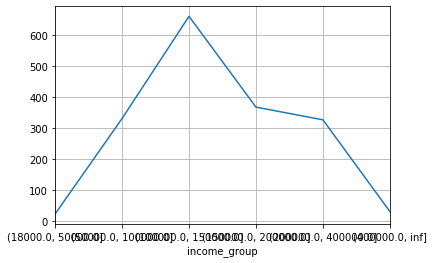

In [85]:
data.groupby('income_group')['debt'].sum().plot(grid=True)

### Вывод

Я точно не смогла решить как лучше поделить на группы по доходам, т.к. можно было распределить людей по примерно одинаковому количеству человек в группе. Но решила остановиться на текущем варианте.

<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Обычно в таких случаях делят по процентилям, используя например 25, 50 и 75 процентили

Я сгруппировала доход людей по группам. Решила, что при группировке нужно отталкиваться от сумм дохода. Все таки у нас есть как и очень маленькие значения как 18 тыс, так и очень больше 2265 тыс. Поэтому я примерно распределила доход. Самой многочисленной группой вышли люди с доходом от 100 до 150 тыс., тут и долгов больше всего. Интересен тот факт, что чем меньше или больше доход, тем долгов меньше. Мы видим, как кривая на графике идет вверх с увеличением дохода и потом спадает. Но у нас не равномерное количество людей по группам. Предполагаю, что люди с меньшим доходом реже обращаются в банк за кредитом. Далее, когда у них увеличивается доход, то они чувствуют себя увереннее в завтрашнем дне и в том, что смогут отдать кредит вовремя, поэтому берут его на одну из групп "целей". Но все может случится. Дальше мы видим спад и, что логично, у людей с большими доходами меньше долгов. Видимо, что они их успели отдать.

- Как разные цели кредита влияют на его возврат в срок?

In [101]:
data.pivot_table(index='new_purpose', values='debt', aggfunc=['count', 'sum', 'mean'])

count  sum      mean
               debt debt      debt
new_purpose                       
автомобиль     4315  403  0.093395
недвижимость  10840  782  0.072140
образование    4022  370  0.091994
свадьба        2348  186  0.079216

### Вывод

Оказалось, что цель неважна для того, чтобы не возвращать кредит в срок. В таблице в колонке mean видно, что от 7,2 до 9,3% должны по кредиту.

<div style="border:solid  red  2px; padding: 20px"> <h1 style="color: red ; margin-bottom:20px">Комментарий наставника</h1>

Выводы не верные, тебе нужно найти процент должников в каждой из категорий и по этому сделать вывод и так же в этом задании требуется использовать сводные таблицы

<div style="border:solid  orange  2px; padding: 20px"> <h1 style="color: orange ; margin-bottom:20px">Комментарий наставника</h1>

Всё верно посчитано, но на будущее - разница в 1-2 % значимая и говорит о том, что зависимость есть

### Шаг 4. Общий вывод

1. Дети заставляют родителей следить за расходами и вовремя возвращать кредит.
2. Брак отрицательно сказывается на выплате кредита в срок, что было неожиданным результатом. Потому что у меня были ожидания увидеть связь с детьми. Семье с обоими работающими родителями будет легче отдавать кредит, как я предполагала. Но ситуация показала, что наличие ребенка и брака не гарант возврата средств вовремя. Возможно, надо посмотреть в цели должников с браке и с детьми.
3. Группа с общим доходом от 100 до 150 тыс. являются большими неплательщиками, чем остальные.
4. Не важно какая цель кредита. До 10% заемщиков должны по кредиту в пределах цели. 

<div style="border:solid  red  2px; padding: 20px"> <h1 style="color: red; margin-bottom:20px">Комментарий наставника</h1>

Посмотрим как изменятся результаты при исправлении неточностей


<div style="border:solid green 2px; padding: 20px"> <h1 style="color:green; margin-bottom:20px">Комментарий наставника</h1>

Точные и обоснованные выводы, супер)

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.

<div style="border:solid  orange  2px; padding: 20px"> <h1 style="color: orange ; margin-bottom:20px">Комментарий наставника</h1>

Работа хорошая, но стоит исправить обозначенные неточности, буду ждать исправленный вариант, удачи!)


<div style="border:solid  green  2px; padding: 20px"> <h1 style="color: green ; margin-bottom:20px">Комментарий наставника</h1>

#### Код

Всё отлично. Из того, что очень порадовало - соблюдена структура проекта, шаги из задания обозначены и выполнены последовательно, код написан аккуратно, используются комментарии к коду, быстро можно понять, какие операции выполняют сложные конструкции. В качестве совета предлагаю глубже изучить и начать чаще применять конструкцию try-except в решении задачи — это улучшит отказоустойчивость кода и обезопасит код от поломок в будущем, а так же изучить средства для построения изображений в Python для более глубокого понимания данных.
#### Выводы

У тебя отлично получается анализировать сложные данные, выдвигать корректные гипотезы и проверять свои выводы на возможность соответствия реальности. Видно глубокое понимание сути проведённого анализа. Было очень интересно проверять твой проект и следить за твоей мыслью, так держать!)


<div style="border:solid  green  2px; padding: 20px"> <h1 style="color: green ; margin-bottom:20px">Комментарий наставника</h1>
Работа принята!) Очень рад, что у тебя всё получилось и надеюсь тебе понравится весь курс, будь усердна и у тебя всё получится! Удачи в будущих проектах)